# Импорты библиотек и данных

In [ ]:
# Общие библиотеки
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
import os
from sklearn.model_selection import train_test_split
import json
from math import sin, cos

# Для создания и обучения модели
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchsummary import summary

# Для работы с изображениями
import cv2
from PIL import Image

# Для визуализации
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip --q "/content/drive/MyDrive/Colab Notebooks/Hackaton/train_dataset_train.zip"
# !unzip --q "/content/drive/MyDrive/Colab Notebooks/Hackaton/train.zip"
!mkdir test
!unzip --q "/content/drive/MyDrive/Colab Notebooks/Hackaton/test_dataset_test.zip" -d test

Archive:  /content/drive/MyDrive/Colab Notebooks/Hackaton/train_dataset_train.zip
   creating: train/
   creating: train/img/
  inflating: train/img/1.png         
  inflating: train/img/100.png       
  inflating: train/img/1000.png      
  inflating: train/img/1003.png      
  inflating: train/img/1004.png      
  inflating: train/img/1005.png      
  inflating: train/img/1006.png      
  inflating: train/img/1008.png      
  inflating: train/img/1009.png      
  inflating: train/img/101.png       
  inflating: train/img/1011.png      
  inflating: train/img/1015.png      
  inflating: train/img/1016.png      
  inflating: train/img/1019.png      
  inflating: train/img/102.png       
  inflating: train/img/1020.png      
  inflating: train/img/1022.png      
  inflating: train/img/1023.png      
  inflating: train/img/1024.png      
  inflating: train/img/1026.png      
  inflating: train/img/1027.png      
  inflating: train/img/1028.png      
  inflating: train/img/1029.png      


# Визуализация

In [ ]:
import cv2
import numpy as np
import collections
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt
import math

In [ ]:
path = '/content/original.tiff'

In [ ]:
data = {"left_top": [2217, 2756], "right_top": [2775, 3615], "left_bottom": [1358, 3314], "right_bottom": [1916, 4173], "angle": 57}

In [ ]:
x_points = [value[0] for value in data.values() if type(value) == list]
y_points = [value[1] for value in data.values() if type(value) == list]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (110166016 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


def angle 305
my angle 270


Text(1054, 4872, 'my')

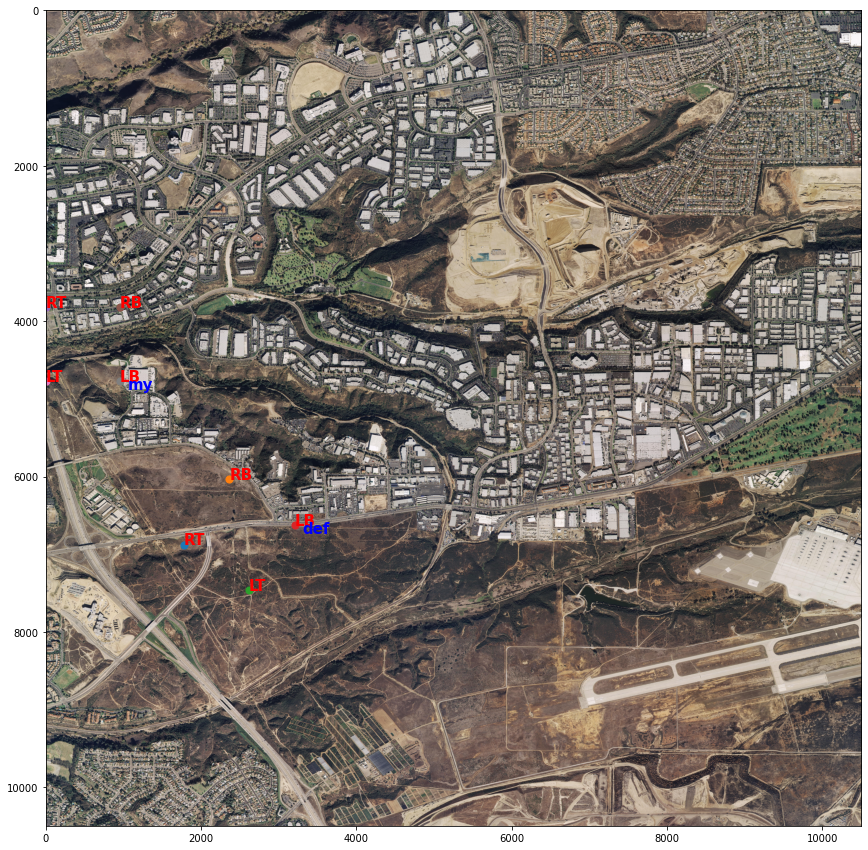

In [ ]:
test_img = Image.open(path)
plt.figure(figsize=(15,15))
plt.imshow(test_img)

data = json.load(open('/content/train/json/998.json'))
print('def angle', data['angle'])
x_points = [value[0] for value in data.values() if type(value) == list]
y_points = [value[1] for value in data.values() if type(value) == list]
for i, c in enumerate(['RT', 'RB', 'LT', 'LB']):
    plt.scatter(x_points[i], y_points[i], s=50)
    plt.annotate(c, xy=(x_points[i], y_points[i]), color='r', size=15, weight='bold')
plt.annotate('def', xy=(x_points[i]+100, y_points[i]+100), color='b', size=15, weight='bold')

data = json.load(open('/content/train/json/data_0_6_270.json'))
print('my angle', data['angle'])
x_points = [value[0] for value in data.values() if type(value) == list]
y_points = [value[1] for value in data.values() if type(value) == list]
for i, c in enumerate(['RT', 'RB', 'LT', 'LB']):
    plt.scatter(x_points[i], y_points[i], s=50)
    plt.annotate(c, xy=(x_points[i], y_points[i]), color='r', size=15, weight='bold')
plt.annotate('my', xy=(x_points[i]+100, y_points[i]+100), color='b', size=15, weight='bold')

## Нарезка подложки для своего датасета

In [ ]:
def ModifiedWay(path, angle):
    rotateImage = cv2.imread(path)
    # Taking image height and width
    imgHeight, imgWidth = rotateImage.shape[0], rotateImage.shape[1]
  
    # Computing the centre x,y coordinates
    # of an image
    centreY, centreX = imgHeight//2, imgWidth//2
  
    # Computing 2D rotation Matrix to rotate an image
    rotationMatrix = cv2.getRotationMatrix2D((centreY, centreX), angle, 1.0)
  
    # Now will take out sin and cos values from rotationMatrix
    # Also used numpy absolute function to make positive value
    cosofRotationMatrix = np.abs(rotationMatrix[0][0])
    sinofRotationMatrix = np.abs(rotationMatrix[0][1])
  
    # Now will compute new height & width of
    # an image so that we can use it in
    # warpAffine function to prevent cropping of image sides
    newImageHeight = int((imgHeight * sinofRotationMatrix) +
                         (imgWidth * cosofRotationMatrix))
    newImageWidth = int((imgHeight * cosofRotationMatrix) +
                        (imgWidth * sinofRotationMatrix))
  
    # After computing the new height & width of an image
    # we also need to update the values of rotation matrix
    rotationMatrix[0][2] += (newImageWidth/2) - centreX
    rotationMatrix[1][2] += (newImageHeight/2) - centreY
  
    # Now, we will perform actual image rotation
    rotatingimage = cv2.warpAffine(
        rotateImage, rotationMatrix, (newImageWidth, newImageHeight))
  
    return rotatingimage

In [ ]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    
    return qx, qy

In [ ]:
def new_coord(x_coord, y_coord, angle, imgH, imgW, originH, originW):
    temp_1, temp_2 = rotate((0, 0), (x_coord - imgH/2, y_coord - imgW/2), math.radians(-angle))
    new_x_coord = temp_1 + originH/2
    new_y_coord = temp_2 + originW/2
    
    return [int(new_y_coord), int(new_x_coord)]

In [ ]:
def best_step(size):
    min_del = size
    for i in range(800, 1100):
        if size % i < min_del:
            mini = i
            min_del = size % i
    return mini, min_del

In [ ]:
def generate_rotated_imgs(path, angle):
    img = ModifiedWay(path, angle)
    
    print('Angle: ', angle)
    
    imgH = img.shape[0]
    print('New Hieght:',imgH)
    
    imgW = img.shape[1]
    print('New Width: ', imgW)

    originH = 10496
    originW = 10496

    step = best_step(img.shape[0])[0]
    print('Best size: ', best_step(img.shape[0]))

    for i in tqdm(range(0, int(imgH/step))):
        for j in range(0, int(imgH/step)):
            data = {}

            x_coord = step * i
            y_coord = step * j

            data['right_top'] = new_coord(x_coord, y_coord + step, angle, imgH, imgW, originH, originW)
            data['right_bottom'] = new_coord(x_coord + step, y_coord + step, angle, imgH, imgW, originH, originW)
            data['left_top'] = new_coord(x_coord, y_coord, angle, imgH, imgW, originH, originW)
            data['left_bottom'] = new_coord(x_coord + step, y_coord, angle, imgH, imgW, originH, originW)
            
#             data['right_top'] = new_coord(y_coord + step, x_coord, angle, imgH, imgW, originH, originW)
#             data['right_bottom'] = new_coord(y_coord + step, x_coord + step, angle, imgH, imgW, originH, originW)
#             data['left_top'] = new_coord(y_coord, x_coord, angle, imgH, imgW, originH, originW)
#             data['left_bottom'] = new_coord(y_coord, x_coord + step, angle, imgH, imgW, originH, originW)
            
            data['angle'] = angle

            img_crop = img[x_coord:x_coord+step, y_coord:y_coord+step]

            unique, counts = np.unique(img_crop, return_counts=True)

            if len(counts) > 0 and counts[0]/counts.sum() < .3:
                cv2.imwrite(f'train/img/out_{i}_{j}_{angle}.png', img_crop)
                with open(f'train/json/out_{i}_{j}_{angle}.json', 'w') as f:
                    json.dump(data, f)

In [ ]:
path = '/home/igor/Hackaton/train_dataset_train/original.tiff'
for angle in tqdm(range(0,360,45)):
    generate_rotated_imgs(path, angle)

# Тренировочный Датасет


In [ ]:
json_dir = "/content/train/json/"

data_df = pd.DataFrame({'id': [],
                        'center_x' : [],
                        'center_y' : [],
                        'angle': []})

json_true = []
for _, _, files in os.walk(json_dir):
  for x in files:
    if x.endswith(".json"):
      data = json.load(open(json_dir + x))
      if 'data' in x:
        #   continue
        #   if int(x.split("_")[3][:-5]) > 180:
        #     continue
          new_row = {'id':f'out_{x.split("_")[1]}_{x.split("_")[2]}_{x.split("_")[3][:-5]}.png',
                     'center_x' : (data["left_top"][0] + data["right_top"][0] + data["left_bottom"][0] + data["right_bottom"][0])/4,
                     'center_y' : (data["left_top"][1] + data["right_top"][1] + data["left_bottom"][1] + data["right_bottom"][1])/4,
                     'angle': data["angle"]}
      else:
         new_row = {'id':x.split(".")[0]+".png",
                    'center_x' : (data["left_top"][0] + data["right_top"][0] + data["left_bottom"][0] + data["right_bottom"][0])/4,
                    'center_y' : (data["left_top"][1] + data["right_top"][1] + data["left_bottom"][1] + data["right_bottom"][1])/4,
                    'angle': data["angle"]}
                    
      data_df = data_df.append(new_row, ignore_index=True)


In [ ]:
data_df.head(5)

,id,center_x,center_y,angle
0,630.png,8123.5,9149.5,263.0
1,738.png,8726.5,8734.5,85.0
2,332.png,1656.5,4575.5,97.0
3,1080.png,1552.5,8464.5,214.0
4,508.png,7646.5,8646.5,99.0


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, labels = self.data_df.iloc[idx]['id'], [self.data_df.iloc[idx]['center_x']/10496, 
                                                            self.data_df.iloc[idx]['center_y']/10496, 
                                                            self.data_df.iloc[idx]['angle']/360]

        # читаем картинку. read the image
        image = cv2.imread(f"/content/train/img/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(labels).float()
    
    def __len__(self):
        return len(self.data_df)

In [ ]:
# задаем преобразование изображения.

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(380),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.RandomResizedCrop(380),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [ ]:
# читаем датасет
# data_df = pd.read_csv("/content/train.csv")

In [ ]:
from os import listdir

print("Обучающей выборки " ,len(listdir("/content/train/img")))
print("Тестовой выборки " ,len(listdir("/content/test/")))

Обучающей выборки  800
Тестовой выборки  400


In [77]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.1)#, random_state=222)

In [78]:
train_df.shape, valid_df.shape

((720, 4), (80, 4))

In [79]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [80]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=20,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=20,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

# Вспомогательные функции

In [ ]:
def compute_metric(data_true, data_pred, outImageW = 10496, outImageH = 10496):

    x_center_true = np.array(data_true[0]).astype(int)
    y_center_true = np.array(data_true[1]).astype(int)

    x_metr = x_center_true - np.array(data_pred[0]).astype(int)
    y_metr = y_center_true - np.array(data_pred[1]).astype(int)

    metr =  1 - (0.7 * (abs(x_metr)/outImageH + abs(y_metr)/outImageW)/2 + 0.3 *abs(data_pred[2] - data_true[2])/360)
    return metr

In [ ]:
def crossvalid(res_model=None,criterion=None,optimizer=None,dataset=None,k_fold=5):
    
    train_score = pd.Series()
    val_score = pd.Series()
    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)
    # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size
        
        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))
        
        train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        train_acc = train(res_model,criterion,optimizer,train_loader,val_loader,1)
        train_score.at[i] = train_acc
        #val_acc = valid(res_model,criterion,optimizer,val_loader)
        #val_score.at[i] = val_acc
    
    return train_score,val_score

In [ ]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [ ]:
def custom_loss(predict, target):
  x_metr = (predict[0] - target[0])
  y_metr = (predict[1] - target[1])

  loss =  0.7 * (torch.abs(x_metr) + torch.abs(y_metr))/2 + 0.3 * torch.abs(predict[2] - target[2])
  return 100 * loss.sum()/len(predict)

In [ ]:
def train(model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    
    mean_acc = 0.5

    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = []

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.cuda()
            labels = labels.cuda()

            y_pred = model(imgs)

            # print(f'train loss size: {len(y_pred)}')

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append((loss.data.cpu().detach().numpy() / y_pred.size(0)) * 100)
            
            y_pred[:, :2] = y_pred[:, :2] * 10496
            y_pred[:, -1] = y_pred[:, -1] * 360

            labels[:, :2] = labels[:, :2] * 10496
            labels[:, -1] = labels[:, -1] * 360

            for label, pr in zip(labels, y_pred):
                    train_pred.append(compute_metric(label.cpu().detach().numpy(), pr.cpu().detach().numpy()))

            optimizer.step()

        train_acc_log.append(train_pred)

        val_loss = 0.
        val_size = 0
        
        val_pred = []
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(imgs)

                # print(f'val loss size: {len(pred)}')
                
                loss = criterion(pred, labels)

                pred[:, :2] = pred[:, :2] * 10496
                pred[:, -1] = pred[:, -1] * 360

                labels[:, :2] = labels[:, :2] * 10496
                labels[:, -1] = labels[:, -1] * 360
                
                val_loss += loss.item()
                val_size += pred.size(0)

                for label, pr in zip(labels, pred):
                    val_pred.append(compute_metric(label.cpu().detach().numpy(), pr.cpu().detach().numpy()))

        val_loss_log.append((val_loss / val_size)*100)
        val_acc_log.append(val_pred)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')

        # if np.mean(train_acc_log) > mean_acc:
        #     # torch.save(model.state_dict(), 'weights.pth')
        #     print('Best model saved, train acc: ', np.mean(train_acc_log))

        mean_acc = np.mean(train_acc_log)

        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train metric:', (np.mean(train_pred)))
        print('Val metric:', (np.mean(val_pred)))
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

# Модели

In [ ]:
torch.cuda.empty_cache()

## ResNet

In [ ]:
# Подргружаем модель

model = models.resnet50(pretrained=True)
lin = model.fc
new_lin = nn.Sequential(
    nn.Linear(lin.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 3),
)

model.fc = new_lin
# model.fc = nn.Linear(2048, 9)

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Hackaton/weights.pth'))
model = model.cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model

In [ ]:
# i = 0
# for param in model.parameters():
#     if i == 159:
#         break
#     param.requires_grad = False
#     print(param)
#     i += 1
# print(i)

In [ ]:
summary(model, (3,400,400))

In [ ]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.00002)
# optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

## EfficentNet

In [ ]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=e601d35e2f75485a58524acc16275b3ab42576e21ce28600951e7f4ca40dc989
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet

In [ ]:
model_name = 'efficientnet-b4'
model_2 = EfficientNet.from_pretrained(model_name)

new_lin = nn.Sequential(
    nn.Linear(1792, 256),
    nn.ReLU(),
    nn.Linear(256, 3),
)

model_2._fc = new_lin

# model_2._fc = nn.Linear(1792,3)
# model_2.load_state_dict(torch.load('/content/weights_2.pth'))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b4


In [ ]:
model_2.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Hackaton/weights_3.pth'))

<All keys matched successfully>

In [ ]:
model_2 = model_2.cuda()

In [ ]:
criterion = torch.nn.MSELoss()
# criterion = custom_loss

In [81]:
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.00005)

In [82]:
torch.cuda.empty_cache()

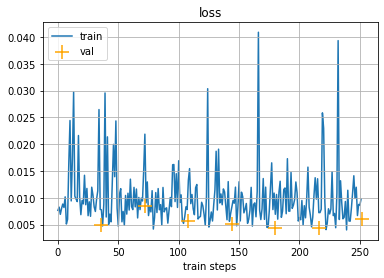

 70%|███████   | 7/10 [05:06<02:10, 43.51s/it]

Train loss: 0.010047295290860347
Val loss: 0.006067625872674398
Train metric: 0.9681203428068769
Val metric: 0.9759211492872819


In [ ]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model_2, 
                                                                 criterion, 
                                                                 optimizer_2, 
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 10)

In [ ]:
# train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, 
#                                                                  criterion, 
#                                                                  optimizer, 
#                                                                  train_loader, 
#                                                                  valid_loader, 
#                                                                  5)

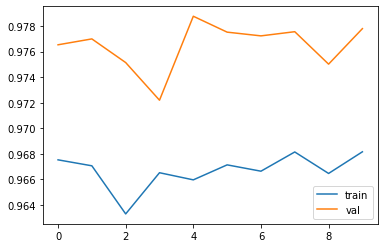

In [76]:
plt.plot(range(len([np.mean(x) for x in train_acc_log])), [np.mean(x) for x in train_acc_log], label='train')
plt.plot(range(len([np.mean(x) for x in train_acc_log])), [np.mean(x) for x in val_acc_log], label='val')
plt.legend()

In [ ]:
np.mean(train_acc_log), np.mean(val_acc_log)

(0.9485513191702537, 0.9704761129287867)

In [ ]:
torch.save(model_2.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Hackaton/weights_3.pth')

## Посчитаем метрику

In [ ]:
total_metric = []

for imgs, labels in valid_loader:
    imgs = imgs.cuda()
    labels = labels.cpu().detach().numpy()            
    pred = model_2(imgs)
    pred = pred.cpu().detach().numpy()    

    pred[:, :2] = pred[:, :2] * 10496
    pred[:, -1] = pred[:, -1] * 360

    labels[:, :2] = labels[:, :2] * 10496
    labels[:, -1] = labels[:, -1] * 360
    
    for label, pr in zip(labels, pred):
        total_metric.append(compute_metric(label, pr))
    
total_metric = np.mean(total_metric)
print('Valid metric:', total_metric)

Valid metric: 0.891480355698888


In [ ]:
# def compute_metric(data_true, data_pred, outImageW = 10496, outImageH = 10496):

#   x_center_true = int((data_true["left_top_x"] + data_true["right_bottom_x"])/2)
#   y_center_true = int((data_true["left_top_y"] + data_true["right_bottom_y"])/2)

#   x_metr = x_center_true - int((data_pred["left_top_x"] + data_pred["right_bottom_x"])/2)
#   y_metr = y_center_true - int((data_pred["left_top_y"] + data_pred["right_bottom_y"])/2) 

#   metr =  1- 0.7 * (abs(x_metr)/outImageH + abs(y_metr)/outImageW)/2 + 0.3 *abs(data_true["angle"] - data_pred["angle"])/359
#   return metr

# Создадим предсказания на тестовом наборе данных

In [ ]:
class TestImageDataset(Dataset):
    def __init__(self, files, transform=None):

        self.files = files
        self.transform = transform

    def __getitem__(self, idx):

        image_name = self.files[idx]

        # читаем картинку. read the image
        image = cv2.imread(f"/content/test/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.files)

In [ ]:
test_images_dir = '/content/test/'

for _, _, test_files in os.walk(test_images_dir):
    break

test_dataset = TestImageDataset(test_files, valid_transform)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=4,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                           )

In [ ]:
torch.cuda.empty_cache()

In [ ]:
indexes = [x.split('.')[0] for x in test_files]
preds = []

for imgs in test_loader:
    imgs = imgs.cuda()            
    pred = model_2(imgs)
    pred = pred.cpu().detach().numpy()
    pred[:, :2] = np.clip(pred[:, :2] * 10496, 0, 10496)
    pred[:, -1] = np.clip(pred[:, -1] * 360, 0, 360)
    preds.extend(list(pred))

In [ ]:
sub_dir = "/content/submission/"
if not os.path.exists(sub_dir):
    os.makedirs(sub_dir)

json_true = []

for indx, pred in zip(indexes, preds):

    pred = [int(x) for x in pred]

    left_top = [pred[0], pred[1]]
    right_top = [pred[0], pred[1]]
    left_bottom = [pred[0], pred[1]]
    right_bottom = [pred[0], pred[1]]
        
    res = {
        'left_top': left_top,
        'right_top': right_top,
        'left_bottom': left_bottom,
        'right_bottom': right_bottom,
        'angle': pred[2]
    }

    with open(sub_dir+indx+'.json', 'w') as f:
        json.dump(res, f)

In [ ]:
!zip -r /content/submission.zip /content/submission

  adding: content/submission/ (stored 0%)
  adding: content/submission/1196.json (deflated 53%)
  adding: content/submission/704.json (deflated 53%)
  adding: content/submission/945.json (deflated 54%)
  adding: content/submission/851.json (deflated 53%)
  adding: content/submission/487.json (deflated 53%)
  adding: content/submission/320.json (deflated 53%)
  adding: content/submission/609.json (deflated 54%)
  adding: content/submission/542.json (deflated 53%)
  adding: content/submission/437.json (deflated 53%)
  adding: content/submission/539.json (deflated 53%)
  adding: content/submission/359.json (deflated 53%)
  adding: content/submission/871.json (deflated 53%)
  adding: content/submission/364.json (deflated 53%)
  adding: content/submission/748.json (deflated 53%)
  adding: content/submission/524.json (deflated 53%)
  adding: content/submission/1063.json (deflated 54%)
  adding: content/submission/885.json (deflated 53%)
  adding: content/submission/790.json (deflated 53%)
  